# Intro
This notebook uses the classes bayesopt4ros and contextual_bayesopt4ros but without using ros.


## Bayesian Optimization Example (Not Contextual)

### Util cell
gets the config file and defines some classes to replace the ros2 related parts.

In [11]:
# this notebook uses the classes bayesopt4ros and contextual_bayesopt4ros but without using ros.
# instead of creating a ros2 server
import os
import glob

from bayesopt4ros.bayesopt import BayesianOptimization
from bayesopt4ros import util
import numpy as np
import test_objectives
import torch

# create a class that replaces the logger of ros2 with functions warning, info, debug and error
class Logger:
    def warning(self, msg):
        print(f'WARNING: {msg}')
    def info(self, msg):
        print(f'INFO: {msg}')
    def debug(self, msg):
        print(f'DEBUG: {msg}')
    def error(self, msg):
        print(f'ERROR: {msg}')

#create a class called goal, which has, goal.x_new, and goal.y_new
class Goal:
    def __init__(self, x_new, y_new, c_new= None):
        self.x_new = x_new
        self.y_new = y_new
        self.c_new = c_new

# get the path of the parent of the current directory
current_dir = os.path.dirname(os.path.realpath(''))
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

print(f'current_dir: {current_dir}')
print(f'parent_dir: {parent_dir}')
yaml_file = glob.glob(os.path.join('../config', 'forrester_ucb.yaml'))[0]
print(yaml_file)



current_dir: /home/fadi/ros2_ws_git_3/src/external_deps/bayesopt4ros/bayesopt4ros
parent_dir: /home/fadi/ros2_ws_git_3/src/external_deps/bayesopt4ros
../config/forrester_ucb.yaml


In [16]:
import matplotlib.pyplot as plt
def plot_gp(mdl, x_min=0, x_max=1):
    x = torch.linspace(x_min, x_max, 100).reshape(-1, 1)
    y = mdl(x)
    y_mean = y.mean.detach()
    y_std = y.stddev.detach()
    plt.plot(x, y_mean)
    plt.fill_between(x.squeeze(), y_mean - y_std, y_mean + y_std, alpha=0.5)
    plt.show()

In [18]:

N_max = 3
bo = BayesianOptimization.from_file(yaml_file, logger=Logger())
func = test_objectives.Forrester()

# triggering the BO algorithm
goal = Goal(0, 0)
x_new = bo.next(goal)
print(f'x_new: {x_new}')
print('-----------')

# run the BO algorithm
for i in range(N_max):
    x_new_tensor = torch.atleast_2d(x_new.clone().detach())
    # x_new_tensor = torch.atleast_2d(torch.tensor(x_new,dtype=torch.double))
    y_new = func(x_new_tensor).squeeze().item()
    goal = Goal(x_new, y_new)
    x_new = bo.next(goal)
    # print(f'iteration {i} :  x_new: {x_new.item():.3f}, y_new: {y_new:.3f}')
    # plot the GP at every iteration
    plot_gp(bo.gp.eval, 0, 1)



INFO: -----------
INFO: feature_names: x1
INFO: outcome_names: y1
x_new: tensor([0.5000], dtype=torch.float64)
-----------


[INFO] [1712855809.553066358] [util]: Logging directory: BO_logs/forrester_ucb/2024-04-11-19-16-49
/home/fadi/.local/lib/python3.10/site-packages/botorch/models/transforms/outcome.py:304: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  stdvs = Y.std(dim=-2, keepdim=True)
/home/fadi/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


TypeError: Model.eval() takes 1 positional argument but 2 were given

# Evaluating the GP at a point

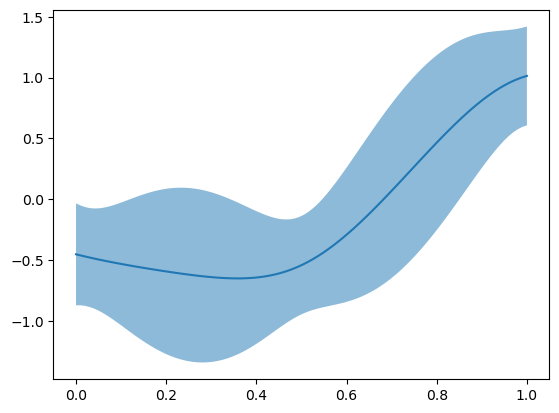

In [15]:
# We want to evaluate the learned GP at a new point
mdl = bo.gp.eval()


    
plot_gp(mdl, 0, 1)


The optimal value found by the BO algorithm

In [51]:
x_opt, f_opt = bo.get_optimal_parameters()
x_best, y_best = bo.get_best_observation()

print(f'x_opt = {x_opt}')
print(f'y_opt = {f_opt}')

print(f'x_best = {x_best}')
print(f'y_best = {y_best}')

x_opt = tensor([0.7571], dtype=torch.float64)
y_opt = -6.026422664372911
x_best = tensor([0.7567], dtype=torch.float64)
y_best = -6.020596949238973


## Contextual Bayesian Optimization Example

In [96]:
# this notebook uses the classes bayesopt4ros and contextual_bayesopt4ros but without using ros.
# instead of creating a ros2 server
import os
import glob

from bayesopt4ros.contextual_bayesopt import ContextualBayesianOptimization 
from bayesopt4ros import util
import numpy as np
import warnings

cbo_yaml_file = glob.glob(os.path.join('../config', 'contextual_forrester_ucb.yaml'))[0]
print(cbo_yaml_file)
func = test_objectives.ContextualForrester()

def sample_context(self) -> np.ndarray:
        """Samples a random context variable to emulate the client."""
        context_bounds = [b for b in self.func._bounds[self.func.input_dim :]]
        # context_bounds = [[-1,22]]
        context = torch.tensor([np.random.uniform(b[0], b[1]) for b in context_bounds],dtype=torch.double)
        return context

N_max = 35
cbo = ContextualBayesianOptimization.from_file(cbo_yaml_file, logger=Logger())

# triggering the CBO algorithm
c_prev = sample_context(cbo)
goal = Goal(0, 0, c_prev)
x_new = cbo.next(goal)
print(f'x_new: {x_new}')

warnings.filterwarnings("ignore", category=UserWarning)
for i in range(N_max):
        # xc_new = torch.cat((torch.tensor(x_new,dtype=torch.double), c_prev))
        xc_new = torch.cat((x_new.clone().detach(), c_prev))
        xc_new_tensor = torch.atleast_2d(xc_new.clone().detach())
        y_new = func(xc_new_tensor).squeeze().item()

        c_new = sample_context(cbo)
        x_new = cbo.next(Goal(x_new, y_new, c_new))
        c_prev = c_new
        print(f'iteration {i} :  x_new: {x_new.item():.3f}, y_new: {y_new:.3f}, c_new: {c_new.item():.3f}')


../config/contextual_forrester_ucb.yaml
x_new: tensor([0.5000], dtype=torch.float64)
iteration 0 :  x_new: 0.750, y_new: 0.909, c_new: 11.096
iteration 1 :  x_new: 0.250, y_new: -3.219, c_new: 7.957


[INFO] [1712685718.485999639] [util]: Logging directory: BO_logs/contextual_forrester_ucb/2024-04-09-20-01-58


iteration 2 :  x_new: 0.375, y_new: -2.200, c_new: 14.773
iteration 3 :  x_new: 0.326, y_new: -1.817, c_new: 20.271
iteration 4 :  x_new: 0.972, y_new: -3.532, c_new: 11.361
iteration 5 :  x_new: 0.678, y_new: 19.783, c_new: 20.896
iteration 6 :  x_new: 0.000, y_new: 0.139, c_new: 7.113
iteration 7 :  x_new: 0.107, y_new: -0.529, c_new: 15.440
iteration 8 :  x_new: 0.635, y_new: -6.828, c_new: 8.723
iteration 9 :  x_new: 0.146, y_new: -0.328, c_new: 11.004
iteration 10 :  x_new: 0.762, y_new: -4.878, c_new: 3.121
iteration 11 :  x_new: 0.000, y_new: -5.193, c_new: 12.229
iteration 12 :  x_new: 0.202, y_new: -3.087, c_new: 16.708
iteration 13 :  x_new: 0.061, y_new: -5.597, c_new: 15.487
iteration 14 :  x_new: 0.085, y_new: -6.460, c_new: 13.181
iteration 15 :  x_new: 0.433, y_new: -5.831, c_new: 0.774
iteration 16 :  x_new: 0.086, y_new: 0.280, c_new: 21.167
iteration 17 :  x_new: 0.717, y_new: -9.143, c_new: 2.683
iteration 18 :  x_new: 0.114, y_new: -4.683, c_new: 8.452
iteration 19 

In [97]:
# testing the learned optimal parameters
results = []
num_test_points = len(func._test_contexts)
# testing on the context points
for context in func._test_contexts:
       results.append(cbo.get_optimal_parameters(context))
# print(results)

id = 0
for context, x_opt, f_opt in zip(
            func._test_contexts,
            func._contextual_optimizer,
            func._contextual_optimal_values,
        ):
            result = results[id]
            print(f'context: {context}| x_opt: {x_opt}, actual: {result[0].item():.3f} | f_opt: {f_opt}, actual: {result[1].item():.3f}')

            np.testing.assert_almost_equal(result[0], x_opt, decimal=2)
            np.testing.assert_almost_equal(result[1], f_opt, decimal=2)
            id += 1
        
print('All tests passed!')


context: [0.0]| x_opt: [0.757], actual: 0.756 | f_opt: -6.021, actual: -6.015
context: [2.0]| x_opt: [0.755], actual: 0.755 | f_opt: -5.508, actual: -5.513
context: [4.0]| x_opt: [0.753], actual: 0.753 | f_opt: -4.999, actual: -5.002
context: [6.0]| x_opt: [0.751], actual: 0.751 | f_opt: -4.494, actual: -4.495
context: [8.0]| x_opt: [0.749], actual: 0.749 | f_opt: -3.993, actual: -3.993
context: [10.0]| x_opt: [0.115], actual: 0.116 | f_opt: -4.705, actual: -4.705
context: [12.0]| x_opt: [0.11], actual: 0.111 | f_opt: -5.48, actual: -5.481
context: [14.0]| x_opt: [0.106], actual: 0.106 | f_opt: -6.264, actual: -6.264
context: [16.0]| x_opt: [0.101], actual: 0.101 | f_opt: -7.057, actual: -7.057
context: [18.0]| x_opt: [0.097], actual: 0.096 | f_opt: -7.859, actual: -7.863
context: [20.0]| x_opt: [0.092], actual: 0.092 | f_opt: -8.67, actual: -8.674
All tests passed!
